# Вяглядит пока как дерьмо, зато работает само))))

In [18]:
import threading
import pandas
import urllib.request
import schedule
import time
import ssl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker

In [347]:
def downloading():
    print('Beginning file download with urllib2...')
    ssl._create_default_https_context = ssl._create_unverified_context
    url = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.xlsx'
    urllib.request.urlretrieve(url, 'covid_data.xlsx')

def run_threaded(downloading):
    job_thread = threading.Thread(target=downloading, daemon = True)
    job_thread.start()

schedule.every().day.at("11:31").do(run_threaded, downloading)


#я чекнул, на сайте обновляется ,каждый день в 11:30, мы будем в 11:31

Every 1 day at 11:31:00 do run_threaded(<function downloading at 0x12daa2378>) (last run: [never], next run: 2020-04-30 11:31:00)

In [ ]:
print('Beginning file download with urllib2...')
url = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.xlsx'
ssl._create_default_https_context = ssl._create_unverified_context
urllib.request.urlretrieve(url, 'covid_data.xlsx')

# это для теста, забей

In [2]:
data = pandas.read_excel('covid_data.xlsx')
data.head()

#считываем данные

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [3]:
data['date'] = pandas.to_datetime(data['date'])
data['date']

#преобразуем даты к божескому виду

0       2020-03-13
1       2020-03-20
2       2020-03-24
3       2020-03-25
4       2020-03-26
           ...    
14085   2020-02-28
14086   2020-02-29
14087   2020-03-01
14088   2020-03-02
14089   2020-03-10
Name: date, Length: 14090, dtype: datetime64[ns]

# Вот здесь надо ввести название страны и все сделается само

In [358]:
country = 'Ukraine'
date_interval = 5 #интервал для графика, забей, не трогай

In [359]:
# для поиска нужной страны в списке
def get_coordinates(country):
    amount = 0
    for i in range(len(data)):
        if data.iloc[i,1] == country:
            amount += 1
            if amount == 1:
                start = i
            end = start + amount
        else:
            pass
    return [start, end, amount]

In [360]:
# Получили координаты страны : индекс начала, индекс конца и длинна этого списка
coordinates = get_coordinates(country)
coordinates

[13160, 13207, 47]

In [361]:
start = coordinates[0]
end = coordinates[1]
amount = coordinates[2]

In [362]:
# функция апроксимации
def f(x, a, b, c):
    return np.exp(a*x + b) + c

In [363]:
# Определили списки количества зараженных
Infected = np.array(data['total_cases'].iloc[start:end])
days = np.arange(1,amount+1)


In [364]:
# Отсеиваем хламную информацию, будем строить минимум от 100 заболевших
def find_new_start(Infected):
    Infected_2 = []
    n = 0
    for i in range(len(Infected)):
        if Infected[i] > 100:
            n += 1
            if n == 1:
                start_new = i
            Infected_2.append(Infected[i])
    Infected_2 = np.array(Infected_2)
    return (Infected_2, start_new)

In [365]:
start_new = find_new_start(Infected)[1]
Infected_2 = find_new_start(Infected)[0]
days1 = np.arange(1,amount-start_new+1)

In [366]:
#Апроксимация


#коэффициенты
beta_opt1, beta_cov1 = curve_fit(f, days1, Infected_2)
a = beta_opt1[0]
b = beta_opt1[1]
c = beta_opt1[2]

print('a = ', a)
print('b = ', b)
print('c = ', c)


#получим погрешности для коэффициентов
sigma_a = np.sqrt(beta_cov1[0,0])
sigma_b = np.sqrt(beta_cov1[1,1])
sigma_c = np.sqrt(beta_cov1[2,2])

print('sigma_a = ', sigma_a)
print('sigma_b = ', sigma_b)
print('sigma_c = ', sigma_c)


residuals1 = Infected_2 - f(days1,*beta_opt1)
fres1 = sum(residuals1**2)
Stand_error = np.sqrt(fres1/len(days1))
print('Stand_error = ', Stand_error)

print('Relative S_r a = % ', 100* sigma_a/a)
print('Relative S_r b = % ', 100* sigma_b/abs(b))
print('Relative S_r c = % ', 100* sigma_c/abs(c))



a =  0.05229061752923753
b =  7.603326404897511
c =  -2340.8508846098034
sigma_a =  0.004194258376722258
sigma_b =  0.1737321246640851
sigma_c =  462.9107661166797
Stand_error =  300.22581244281514
Relative S_r a = %  8.02105344113999
Relative S_r b = %  2.2849489212008507
Relative S_r c = %  19.775320553741395


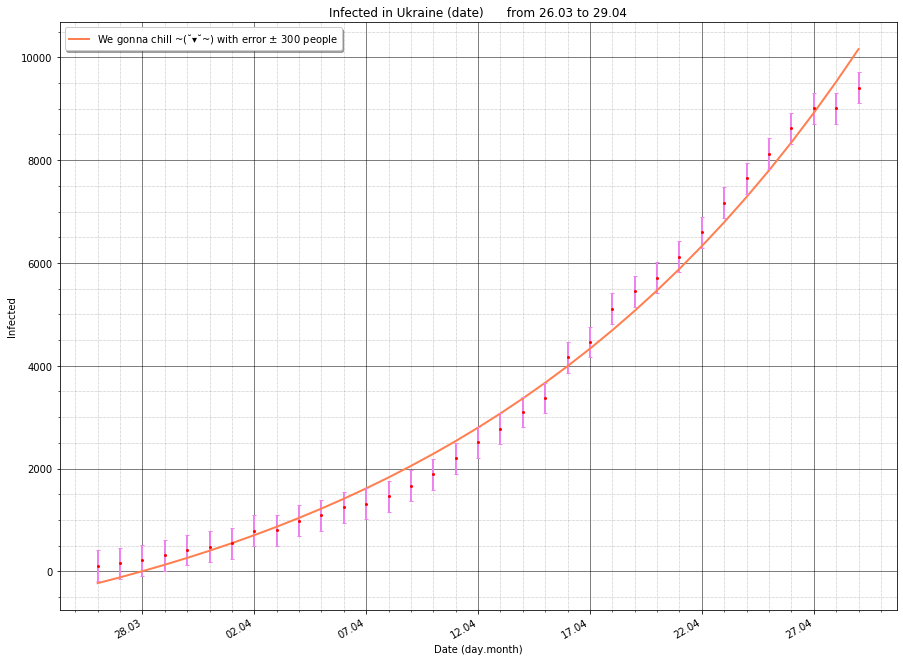

In [367]:
fig, ax = plt.subplots(figsize=(15, 12))

past = min(data['date'].iloc[start+start_new:end])
now = max(data['date'].iloc[start+start_new:end]) + dt.timedelta(days=1)
days2 = mdates.drange(past,now,dt.timedelta(days=1))


delta = days2[0] - 1
beta_opt2 = np.array([a,b-delta * a,c])



ax.plot(days2, f(days2, *beta_opt2), 'coral', lw=2)
#ax.plot(days2, Infected, 'coral', lw=2)
#ax.scatter(days2, Infected, s = 1, c = 'red')
lgnd = ax.legend(['We gonna chill ~(˘▾˘~) with error $\pm$ %d people' % Stand_error ], loc='upper left', shadow=True)

ax.set_title('Infected in %s (date)      from %s to %s' % (country, min(data['date'].iloc[start+start_new:end]).strftime("%d.%m"), max(data['date'].iloc[start+start_new:end]).strftime("%d.%m")))
ax.set_ylabel('Infected')
ax.set_xlabel('Date (day.month)')

ax.grid(which='major',
        color = 'k')

ax.minorticks_on()

ax.grid(which='minor',
        color = 'gray',
        linestyle = ':', linewidth = 0.5)

ax.grid(which='major', linewidth = 0.5)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=date_interval))
plt.errorbar(days2, Infected_2, fmt = 'ro', markersize = '2', yerr = Stand_error, capsize = 2, elinewidth = 2, capthick = 1, ecolor = 'violet')
plt.gcf().autofmt_xdate()
plt.savefig('infected2.pdf')
plt.show()



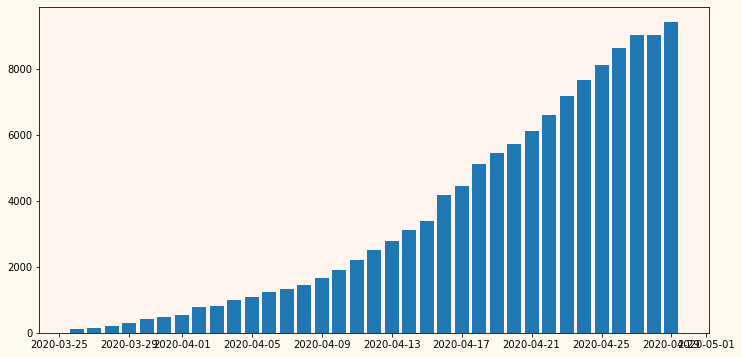

In [369]:
# я пытаюсь построить гистограмму, выглядит пока как дерьмо ,зато работает само ))))

fig, ax = plt.subplots()

ax.bar(data['date'].iloc[start+start_new:end], Infected_2)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    
fig.set_figheight(6)    
plt.savefig('infected_hist.pdf')
plt.show()